In [129]:
import pandas as pd
import numpy as np
import seaborn as sns
import statsmodels
import linearmodels
import matplotlib as plt
import xlrd
import scipy
import os
import statsmodels.api as sm
from pandas.plotting import autocorrelation_plot
import pandas_profiling
from linearmodels.panel import PanelOLS

%matplotlib inline

In [130]:
# read data file, convert to csv
data = pd.read_excel('data/fpds_rates.xlsx')

In [131]:
data.columns

Index(['AgencyWide', 'department_id', 'department_name',
       'contracting_agency_id', 'contracting_agency_name', 'FiscalYear',
       'TotalActions', 'TotalDollars', 'CompetedActions', 'CompetedDollars',
       'CompRate', 'NotCompetedActions', 'NotCompetedDollars', 'NotCompRate',
       'OneBidActions', 'OneBidDollars', 'OneBidRate', 'EffCompActions',
       'EffCompDollars', 'EffCompRate', 'SbActions', 'SbDollars', 'SbUtilRate',
       'SdbActions', 'SdbDollars', 'SdbRate', 'WosbActions', 'WosbDollars',
       'WosbRate', 'SdvosbcActions', 'SdvosbcDollars', 'SdvosbcRate',
       'HubZoneActions', 'HubZoneDollars', 'HubZoneRate', 'OtsbActions',
       'OtsbDollars', 'OtsbRate', 'EligibleActions', 'EligibleDollars',
       'SB+OTSB', 'OneBidRate+EffCompRate'],
      dtype='object')

In [132]:
len(data)

1171

# Intro
 
Here we're trying to recreate a fixed effects panel regression written in the proprietary econometric software EViews. We only have the summary output of that model, which is specified as:

`EffCompRate ~ C + NotCompRate(-1) + OneBidRate + SdbRate`

These variables are defined as follows:
 - **EffCompRate:** Total Competed Dollars with 2 or more bids / Total Competed Dollars
 - **NotCompRate:** Total Not Competed Dollars / Total Obligations
 - **OneBidRate:** Total Competed Dollars with only 1 bid / Total Competed Dollars
 - **SdbRate:** Total Small Disadvantaged Business Dollars / Total Small Business Eligible Dollars

Some research into EViews leads us to believe that this model was fit using fixed entity effects alone.

Inspecting the model specification, we notice first and foremost that each variable is a ratio measurement, with a few common/similar terms in the numerators and denominators. For example, the OneBidRate should sum to one when added to the EffCompRate. Additionally, one should also be able to calculate the total competed dollars by summing the numerators in OneBidRate and EffCompRate. This knowledge will both help and hinder us, as interrealted ratio components like this bake a sort of statistical dependency into our data that can impact our coeffecient estimates as well as inferences. It also fortunately furnishes us with an opportunity to assess data quality, as all of these calculations should work out perfectly in the absence of data issues.

Moreover, we notice that there's a common denominator for both the IV (EffCompRate) and one of the DVs (OneBidRate). In this situation, we could re-write the regression equation by factoring out the common denominator as a separate right-hand term and then demonstrate that there is a correlation between the independent variable with the common component and the error term. This essentially renders the relationship between that IV and the DV in the orginal model as definitionally spurious. 

Finally, we suspect that there will be some multicolinearity issues with these variables. All of the variables are functions of total dollars obligated. If one moves a certain percentage then another will definitionally move in proportion. This lack of independence problematizes coefficient interpretation as we can attribute a change in $y$ to a change in $x$ *holding all other things constant*.

In short, we'd advise against interpreting the results of this model specification. The negative consequences of doing so would be further compounded if data quality issues are discovered (spoiler alert:  we find some).


## Purpose / Path Forward

Since we're building this model for documentation purpoes, we're merely going to recreate it as originally specified. Then we'll run through several "what-if" scenarios use Monte Carlo simulations to demonstrate the methodological flaws. 


## Possible Sources of Error / Assumptions

Since we only have the model output, we're not certain how the data was cleansed prior to fitting. We're also not entirely sure whether or not time *and* cross-sectional fixed effects were modeled. We'll assume both were.

# Data Cleaning

In [145]:
data.head()

,AgencyWide,department_id,department_name,contracting_agency_id,contracting_agency_name,FiscalYear,TotalActions,TotalDollars,CompetedActions,CompetedDollars,...,HubZoneActions,HubZoneDollars,HubZoneRate,OtsbActions,OtsbDollars,OtsbRate,EligibleActions,EligibleDollars,SB+OTSB,OneBidRate+EffCompRate
0,1,300,LIBRARY OF CONGRESS,NaN,NaN,2014,24,0.0,24,0.0,...,0.0,0.0,NaN,21.0,0.0,NaN,24.0,0.0,NaN,NaN
1,1,300,LIBRARY OF CONGRESS,NaN,NaN,2015,10,0.0,10,0.0,...,0.0,0.0,NaN,6.0,0.0,NaN,10.0,0.0,NaN,NaN
2,1,300,LIBRARY OF CONGRESS,NaN,NaN,2016,7,0.0,6,0.0,...,0.0,0.0,NaN,4.0,0.0,NaN,7.0,0.0,NaN,NaN
3,1,300,LIBRARY OF CONGRESS,NaN,NaN,2017,18,0.0,18,0.0,...,1.0,0.0,NaN,7.0,0.0,NaN,18.0,0.0,NaN,NaN
4,0,300,LIBRARY OF CONGRESS,300,LIBRARY OF CONGRESS,2014,24,0.0,24,0.0,...,0.0,0.0,NaN,21.0,0.0,NaN,24.0,0.0,NaN,NaN


In [146]:
#drop agency-wide observations
data1 = data[data['AgencyWide']!=1]
# some records have not obligated dollars, so I'll drop those as it does not make sense to include agencies who
# did not participate in any contracting actions in a regression measuring the dollar impact of 
#contracting actions. Also certain rates used in the regression use TotalDollars in the denominator
data1 = data1[data1['TotalDollars']>0]
# remove negatives
data1= data1[data1['OneBidRate']>0]
data1 = data1[data1['SdbRate']>0]
data1 = data1[data1['NotCompRate']>0]
data1 = data1[data1['EffCompRate']>0]

len(data1)

761

# EDA

In [147]:
df = data1[['SdbRate', 'OneBidRate', 'NotCompRate', 'EffCompRate', 'FiscalYear', 'contracting_agency_name']]

In [148]:
pandas_profiling.ProfileReport(df)

Number of variables,7
Number of observations,761
Total Missing (%),0.0%
Total size in memory,41.7 KiB
Average record size in memory,56.1 B
Numeric,6
Categorical,1
Boolean,0
Date,0
Text (Unique),0
Rejected,0


## Data Validation

Above, we saw that the OneBidRate should sum to one when added to the EffCompRate. We'll check that below to identify data validity issues:



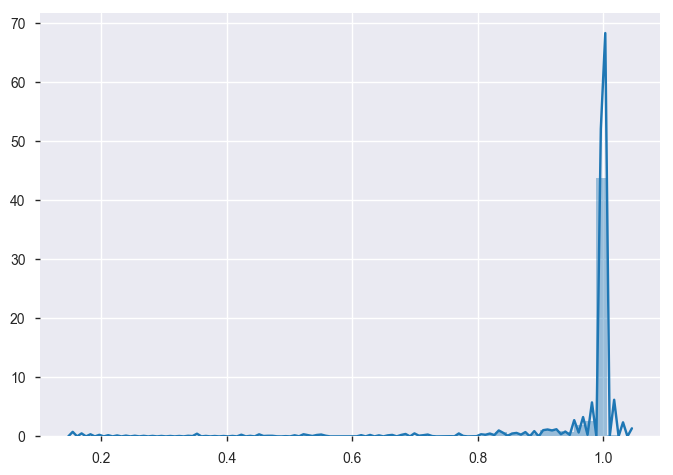

In [149]:
sum_to_one = df['OneBidRate'] + df['EffCompRate']
sns.distplot(sum_to_one)

It seems that not every value record sums to one, indicating some data quality issues. Let's inspect further by rounding each sum to the nearest tenth.

In [150]:
sum_to_one.round(decimals = 1).value_counts()

1.0    662
0.9     49
0.8     20
0.7     11
0.5      9
0.6      5
0.4      3
0.2      1
0.3      1
dtype: int64

In [151]:
no_sum_to_one = sum_to_one.round(decimals = 1).value_counts().sum() - 662
print(f"{no_sum_to_one} of {sum_to_one.round(decimals = 1).value_counts().sum()} records do not sum to one.")

99 of 761 records do not sum to one.


About 13% of the records to do not sum to one as they should. We should either drop these observations from the analysis or fit models using probabilistic (e.g. bootstrap) methods. 

Another data quality issue we could check is whether or not $OneBidDollars + EffCompDollars = CompetedDollars$

In [152]:
competed_dollars = data1['CompetedDollars']
one_bid_dollars = data1['OneBidDollars']
eff_comp_dollars = data1['EffCompDollars']
actual_competed_dollars = one_bid_dollars + eff_comp_dollars
dif = competed_dollars - actual_competed_dollars
dif.abs().round().describe()

count    7.610000e+02
mean     4.931484e+07
std      3.129912e+08
min      0.000000e+00
25%      0.000000e+00
50%      3.182300e+04
75%      1.986108e+06
max      5.732543e+09
dtype: float64

The above finding is also alarming, suggesting that there are serious data quality issues at play here. Nevertheless, we'll proceed to fit a model for documentation purposes.

# Panel OLS
Here we'll fit a panel least sqaures model using fixed effects for both time and entities.

In [153]:
year = pd.Categorical(df.FiscalYear)
design_df = df.set_index(['contracting_agency_name','FiscalYear'])
design_df['FiscalYear'] = year
design_df['NotCompRate_shift'] = design_df['NotCompRate'].shift(1)
design_df = design_df[design_df['FiscalYear'] != 2014]

In [154]:
design_df.head()

SdbRate  OneBidRate  \
contracting_agency_name           FiscalYear                         
GAO, EXCEPT COMPTROLLER GENERAL   2015        0.113739    0.530569   
                                  2016        0.070126    0.617649   
                                  2017        0.111525    0.571683   
                                  2018        0.147277    0.761902   
EXECUTIVE OFFICE OF THE PRESIDENT 2015        0.093796    0.552590   

                                              NotCompRate  EffCompRate  \
contracting_agency_name           FiscalYear                             
GAO, EXCEPT COMPTROLLER GENERAL   2015           0.189831     0.469430   
                                  2016           0.144780     0.382350   
                                  2017           0.228889     0.428168   
                                  2018           0.244115     0.158253   
EXECUTIVE OFFICE OF THE PRESIDENT 2015           0.386121     0.447480   

                                             FiscalYear  NotCompRate_shift  
contracting_agency_name           FiscalYear                                
GAO, EXCEPT COMPTROLLER GENERAL   2015             2015           0.200121  
                                  2016             2016           0.189831  
                                  2017             2017           0.144780  
                                  2018             2018           0.228889  
EXECUTIVE OFFICE OF THE PRESIDENT 2015             2015           0.423876

In [156]:
exog_cols = ['SdbRate','OneBidRate','NotCompRate_shift']
exog = sm.add_constant(design_df[exog_cols])
model = PanelOLS(design_df.EffCompRate,
                 exog,
                 entity_effects = True,
                 time_effects = True).fit()
print(model)

                          PanelOLS Estimation Summary                           
Dep. Variable:            EffCompRate   R-squared:                        0.5860
Estimator:                   PanelOLS   R-squared (Between):              0.9052
No. Observations:                 608   R-squared (Within):               0.5166
Date:                Mon, May 13 2019   R-squared (Overall):              0.7770
Time:                        14:44:40   Log-likelihood                    738.18
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                      210.42
Entities:                         157   P-value                           0.0000
Avg Obs:                       3.8726   Distribution:                   F(3,446)
Min Obs:                       0.0000                                           
Max Obs:                       13.000   F-statistic (robust):             210.42
                            

# Simulations
Here we'll randomly generate data such that the OneBidRate does sum to one when added to the EffCompRate. We'll do this a couple thousand times, generating the same model as specified above. For each fit, we'll save the coeffecient parameter estimates and then perform some summary statistics on them to get a measure of the vagaries introduced by our poor data. 

In [ ]:
#TODO run simulations

# Summary

1. Monte Carlo Simulations
TODO - report results here.

2. Model Specification
A common denominator for the IV (EffCompRate) and one of the DVs (OneBidRate) suggests that we'd be able to re-write the regression equation with the denomonitor factored out as a separate term to demonstrate that there is a correlation between OneBidRate and the error term. This essentially renders the relationship between that IV and the DV as definitionally spurious.